In [3]:
import numpy as np
from PIL import Image
import torch as th
import matplotlib.pyplot as plt
import glob, os

/data/mint/DPM_Dataset/ffhq_256_with_anno///shadow_diff/futschik_2e-1//train/25081.png


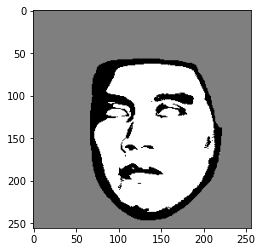

In [13]:
dat_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
sd_path = '/shadow_diff/futschik_2e-1/'
set_ = 'train'

# for p in glob.glob(f'{dat_path}/{sd_path}/{set_}/*'):
p = glob.glob(f'{dat_path}/{sd_path}/{set_}/*')[2]
print(p)
plt.imshow(Image.open(p), cmap='gray')
plt.show()